In [1]:
import requests
import json
import pandas as pd

# Extract
url = "https://environment.data.gov.uk/flood-monitoring/id/floods"
response = requests.get(url)
data = response.json()

# Transform
floods = []
for item in data['items']:
    flood = {
        'id': item['@id'],
        'description': item['description'],
        'severity': item['severity'],
        'severityLevel': item['severityLevel'],
        'timeRaised': item['timeRaised'],
        'floodAreaID': item['floodAreaID'],
        'county': item['floodArea']['county'],
        'riverOrSea': item['floodArea']['riverOrSea']
    }
    floods.append(flood)

# Load
df = pd.DataFrame(floods)
df.to_csv('flood_data.csv', index=False)


In [7]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import geopy

# Load the data
df = pd.read_csv('flood_data.csv')

# Initialize geocoder
geolocator = geopy.geocoders.Nominatim(user_agent="flood_map")

# Create a map centered on the UK
m = folium.Map(location=[54.5, -4], zoom_start=6)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Define color mapping for severity levels
color_map = {2: 'red', 3: 'orange', 4: 'green'}

# Add markers for each flood alert/warning
for _, row in df.iterrows():
    color = color_map.get(row['severityLevel'], 'blue')
    
    # Geocode the county
    location = geolocator.geocode(f"{row['county']}, UK")
    
    if location:
        folium.Marker(
            location=[location.latitude, location.longitude],
            popup=f"<b>{row['description']}</b><br>Severity: {row['severity']}<br>River: {row['riverOrSea']}<br>County: {row['county']}<br>Time: {row['timeRaised']}",
            icon=folium.Icon(color=color)
        ).add_to(marker_cluster)

# Add a legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 90px; 
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    ">&nbsp; <b>Flood Severity</b> <br>
    &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>&nbsp; Flood Warning <br>
    &nbsp; <i class="fa fa-map-marker fa-2x" style="color:orange"></i>&nbsp; Flood Alert <br>
    &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i>&nbsp; Warning No Longer in Force
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map
m.save('uk_flood_map.html')


In [8]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_output = np.zeros((1, self.output_size))
    
    def forward(self, X):
        self.hidden = sigmoid(np.dot(X, self.weights_input_hidden) + self.bias_hidden)
        self.output = sigmoid(np.dot(self.hidden, self.weights_hidden_output) + self.bias_output)
        return self.output
    
    def backward(self, X, y, output):
        self.output_error = y - output
        self.output_delta = self.output_error * sigmoid_derivative(output)
        
        self.hidden_error = self.output_delta.dot(self.weights_hidden_output.T)
        self.hidden_delta = self.hidden_error * sigmoid_derivative(self.hidden)
        
        self.weights_hidden_output += self.hidden.T.dot(self.output_delta)
        self.bias_output += np.sum(self.output_delta, axis=0, keepdims=True)
        self.weights_input_hidden += X.T.dot(self.hidden_delta)
        self.bias_hidden += np.sum(self.hidden_delta, axis=0, keepdims=True)
    
    def train(self, X, y, epochs):
        for _ in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output)
    
    def predict(self, X):
        return self.forward(X)

# Cricket data: [runs, wickets, overs, strike_rate, economy_rate]
X = np.array([
    [85, 2, 4.0, 150.0, 6.5],
    [42, 1, 3.2, 131.25, 7.8],
    [63, 3, 3.5, 180.0, 5.7],
    [29, 0, 2.0, 145.0, 8.5],
    [71, 2, 4.0, 177.5, 6.2]
])

# Target: 1 if performance is good, 0 otherwise
y = np.array([[1], [0], [1], [0], [1]])

# Normalize the input data
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Create and train the neural network
nn = NeuralNetwork(input_size=5, hidden_size=4, output_size=1)
nn.train(X, y, epochs=10000)

# Make predictions
predictions = nn.predict(X)
print("Predictions:")
for i, pred in enumerate(predictions):
    print(f"Record {i+1}: {pred[0]:.4f} ({'Good' if pred[0] > 0.5 else 'Not Good'})")


Predictions:
Record 1: 0.9944 (Good)
Record 2: 0.0069 (Not Good)
Record 3: 0.9987 (Good)
Record 4: 0.0014 (Not Good)
Record 5: 0.9978 (Good)


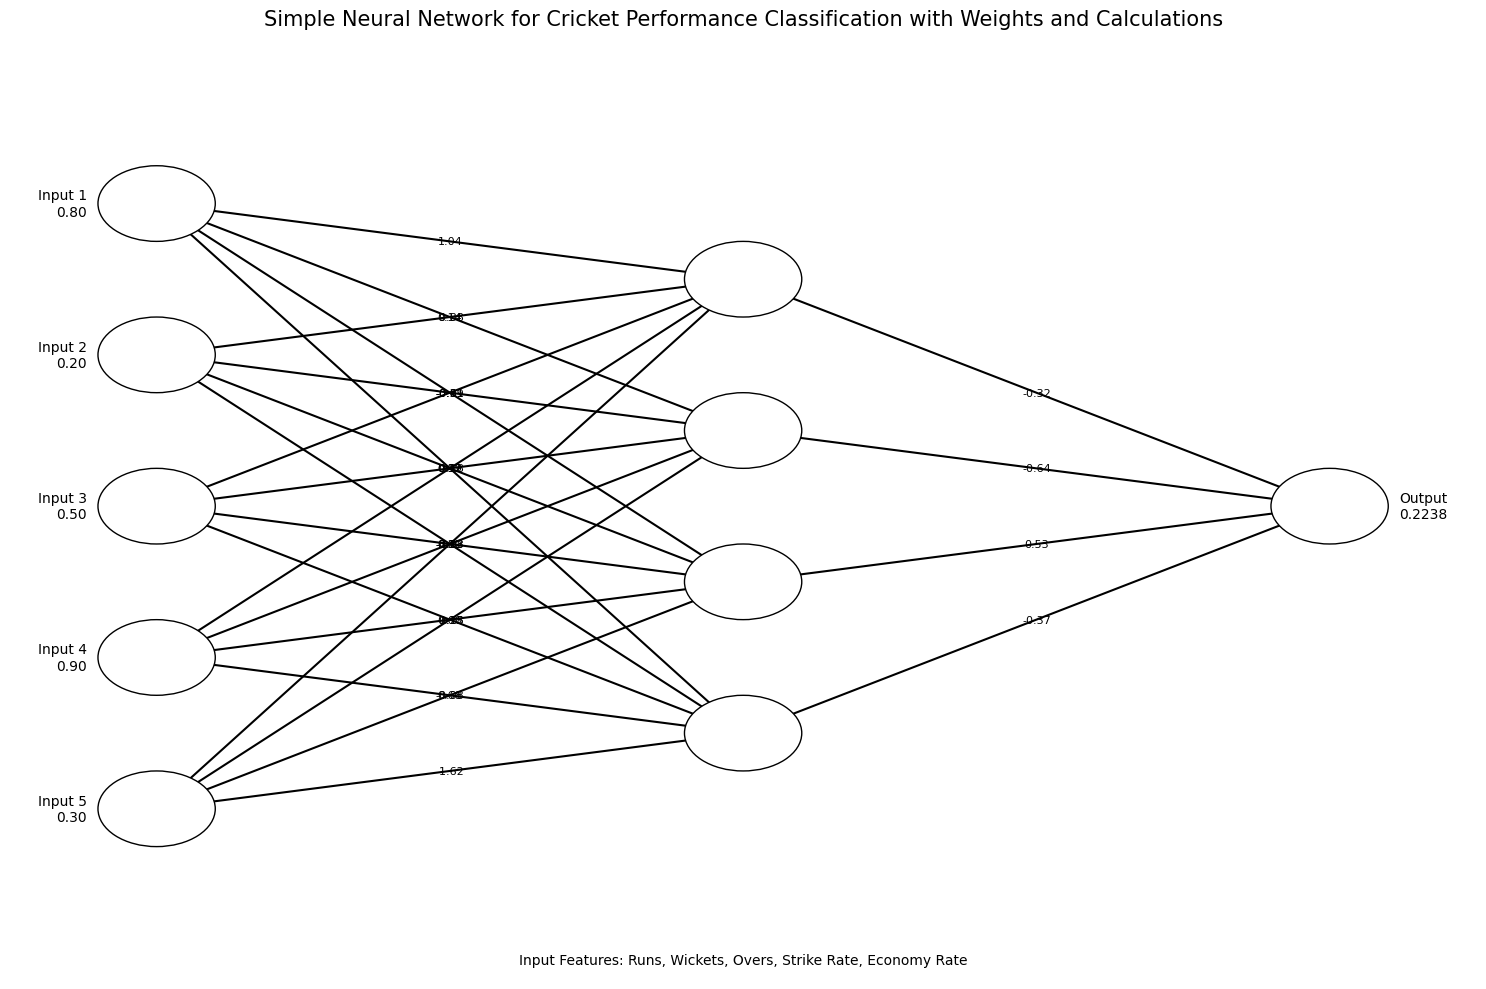

In [12]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_hidden = np.random.randn(hidden_size)
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.random.randn(output_size)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def draw_neural_net(ax, left, right, bottom, top, layer_sizes, weights, biases):
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Input values (example)
    input_values = [0.8, 0.2, 0.5, 0.9, 0.3]
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            if n == 0:
                plt.annotate(f'Input {m+1}\n{input_values[m]:.2f}', xy=(n*h_spacing + left, layer_top - m*v_spacing),
                             xytext=(-50, 0), ha='right', va='center', textcoords='offset points')
            elif n == len(layer_sizes) - 1:
                output = sigmoid(np.dot(sigmoid(np.dot(input_values, weights[0]) + biases[0]), weights[1]) + biases[1])
                plt.annotate(f'Output\n{output[0]:.4f}', xy=(n*h_spacing + left, layer_top - m*v_spacing),
                             xytext=(50, 0), ha='left', va='center', textcoords='offset points')
            else:
                hidden_output = sigmoid(np.dot(input_values, weights[0]) + biases[0])
                plt.annotate(f'H{m+1}\n{hidden_output[m]:.4f}', xy=(n*h_spacing + left, layer_top - m*v_spacing),
                             xytext=(0, 0), ha='center', va='center', textcoords='offset points')

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
                weight = weights[n][m, o]
                plt.annotate(f'{weight:.2f}', xy=((n + 0.5)*h_spacing + left, (layer_top_a + layer_top_b)/2 - (m + o)*v_spacing/2),
                             xytext=(0, 0), ha='center', va='center', textcoords='offset points', fontsize=8)

# Create the neural network
nn = NeuralNetwork(input_size=5, hidden_size=4, output_size=1)

# Set up the plot
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.axis('off')

# Draw the neural network
draw_neural_net(ax, .1, .9, .1, .9, [nn.input_size, nn.hidden_size, nn.output_size], 
                [nn.weights_input_hidden, nn.weights_hidden_output],
                [nn.bias_hidden, nn.bias_output])

# Add title and labels
plt.title("Simple Neural Network for Cricket Performance Classification with Weights and Calculations", fontsize=15)
plt.text(0.5, 0.02, 'Input Features: Runs, Wickets, Overs, Strike Rate, Economy Rate', ha='center', va='center', transform=ax.transAxes, fontsize=10)

plt.tight_layout()
plt.show()


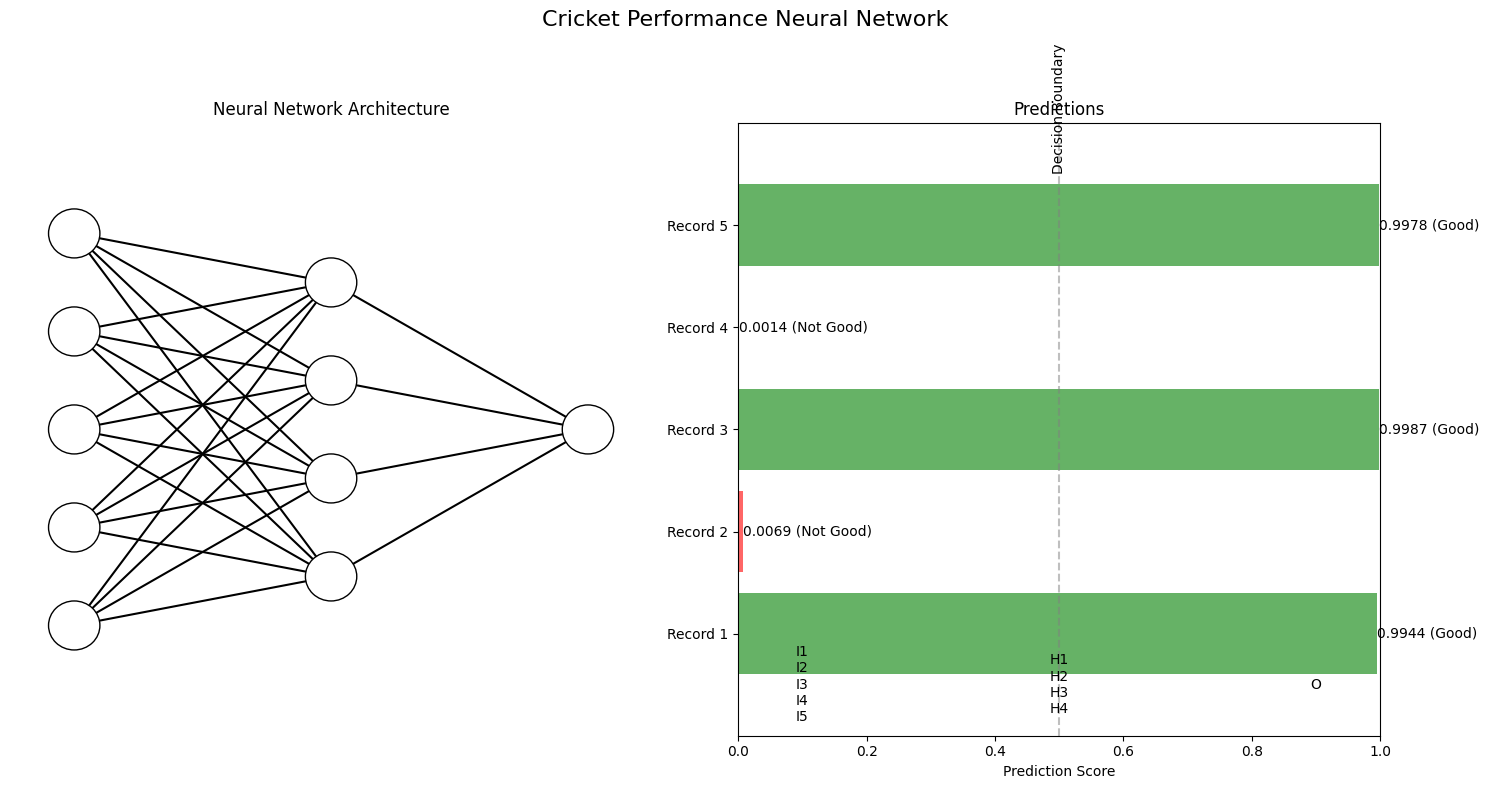

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data
records = [
    [85, 2, 4.0, 150.0, 6.5],
    [42, 1, 3.2, 131.25, 7.8],
    [63, 3, 3.5, 180.0, 5.7],
    [29, 0, 2.0, 145.0, 8.5],
    [71, 2, 4.0, 177.5, 6.2]
]

predictions = [0.9944, 0.0069, 0.9987, 0.0014, 0.9978]
labels = ['Good', 'Not Good', 'Good', 'Not Good', 'Good']

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Cricket Performance Neural Network', fontsize=16)

# Neural Network Visualization
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            if n == 0:
                plt.text(n*h_spacing + left, layer_top - m*v_spacing, f'I{m+1}', ha='center', va='center')
            elif n == len(layer_sizes) - 1:
                plt.text(n*h_spacing + left, layer_top - m*v_spacing, 'O', ha='center', va='center')
            else:
                plt.text(n*h_spacing + left, layer_top - m*v_spacing, f'H{m+1}', ha='center', va='center')

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

draw_neural_net(ax1, .1, .9, .1, .9, [5, 4, 1])
ax1.set_title('Neural Network Architecture')
ax1.axis('off')

# Predictions Visualization
ax2.set_title('Predictions')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 6)
ax2.set_xlabel('Prediction Score')
ax2.set_yticks(range(1, 6))
ax2.set_yticklabels([f'Record {i}' for i in range(1, 6)])

for i, (pred, label) in enumerate(zip(predictions, labels)):
    color = 'green' if label == 'Good' else 'red'
    ax2.barh(i+1, pred, color=color, alpha=0.6)
    ax2.text(pred, i+1, f'{pred:.4f} ({label})', va='center')

ax2.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.text(0.5, 5.5, 'Decision Boundary', rotation=90, va='bottom', ha='center')

plt.tight_layout()
plt.show()
